In [204]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_iris
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [205]:
iris = load_iris()
X = pd.DataFrame(iris.data, columns=iris.feature_names)
y = pd.Categorical.from_codes(iris.target, iris.target_names)

In [206]:
print(X)
print(y)

     sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                  5.1               3.5                1.4               0.2
1                  4.9               3.0                1.4               0.2
2                  4.7               3.2                1.3               0.2
3                  4.6               3.1                1.5               0.2
4                  5.0               3.6                1.4               0.2
..                 ...               ...                ...               ...
145                6.7               3.0                5.2               2.3
146                6.3               2.5                5.0               1.9
147                6.5               3.0                5.2               2.0
148                6.2               3.4                5.4               2.3
149                5.9               3.0                5.1               1.8

[150 rows x 4 columns]
['setosa', 'setosa', 'setosa', 'setosa',

In [207]:
X.shape

(150, 4)

In [208]:
df = X.join(pd.Series(y, name='class'))

In [209]:
df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [210]:
class_feature_means = pd.DataFrame(columns=iris.target_names)
for c, rows in df.groupby('class'):
    class_feature_means[c] = rows.mean()
class_feature_means

,setosa,versicolor,virginica
sepal length (cm),5.006,5.936,6.588
sepal width (cm),3.428,2.770,2.974
petal length (cm),1.462,4.260,5.552
petal width (cm),0.246,1.326,2.026


In [211]:
within_class_scatter_matrix = np.zeros((4,4))
for c, rows in df.groupby('class'):
    rows = rows.drop(['class'], axis=1)
    s = np.zeros((4,4))
for index, row in rows.iterrows():
    x, mc = row.values.reshape(4,1), class_feature_means[c].values.reshape(4,1)
    s += (x - mc).dot((x - mc).T)
    within_class_scatter_matrix += s
print(within_class_scatter_matrix)

[[588.2732 140.8686 451.7852  62.6338]
 [140.8686 140.4603 105.7746  63.2599]
 [451.7852 105.7746 442.0604  71.995 ]
 [ 62.6338  63.2599  71.995   89.2099]]


In [212]:
feature_means = df.mean()
between_class_scatter_matrix = np.zeros((4,4))
for c in class_feature_means:    
    n = len(df.loc[df['class'] == c].index)
    mc, m = class_feature_means[c].values.reshape(4,1), feature_means.values.reshape(4,1)
    between_class_scatter_matrix += n * (mc - m).dot((mc - m).T)
print(between_class_scatter_matrix)

[[ 63.21213333 -19.95266667 165.2484      71.27933333]
 [-19.95266667  11.34493333 -57.2396     -22.93266667]
 [165.2484     -57.2396     437.1028     186.774     ]
 [ 71.27933333 -22.93266667 186.774       80.41333333]]


In [213]:
eigen_values, eigen_vectors = np.linalg.eig(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix))

In [214]:
for i in range(len(eigen_values)):
    eigvec_sc = eigen_vectors[:,i].reshape(4,1)   
    print('\nEigenvector {}: \n{}'.format(i+1, eigvec_sc.real))
    print('Eigenvalue {:}: {:.2e}'.format(i+1, eigen_values[i].real))


Eigenvector 1: 
[[-0.34775603]
 [-0.45247827]
 [ 0.59991143]
 [ 0.56074543]]
Eigenvalue 1: 3.33e+00

Eigenvector 2: 
[[ 0.04493799]
 [-0.86758755]
 [ 0.07406326]
 [-0.48968057]]
Eigenvalue 2: 2.70e-02

Eigenvector 3: 
[[-0.02496238]
 [-0.23708424]
 [-0.28897521]
 [ 0.62570947]]
Eigenvalue 3: -2.03e-16

Eigenvector 4: 
[[-0.02496238]
 [-0.23708424]
 [-0.28897521]
 [ 0.62570947]]
Eigenvalue 4: -2.03e-16


In [215]:
for i in range(len(eigen_values)):
    eigv = eigen_vectors[:,i].reshape(4,1)
    np.testing.assert_array_almost_equal(np.linalg.inv(within_class_scatter_matrix).dot(between_class_scatter_matrix).dot(eigv),
                                         eigen_values[i] * eigv,
                                         decimal=6, err_msg='', verbose=True)
#print('ok')

In [216]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eigen_values[i]), eigen_vectors[:,i]) for i in range(len(eigen_values))]

# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs = sorted(eig_pairs, key=lambda k: k[0], reverse=True)

# Visually confirm that the list is correctly sorted by decreasing eigenvalues

print('Eigenvalues in decreasing order:\n')
for i in eig_pairs:
    print(i[0])

Eigenvalues in decreasing order:

3.3340137930233347
0.027034739042874168
3.379438918053471e-16
3.379438918053471e-16


In [217]:
print('Variance explained:\n')
eigv_sum = sum(eigen_values)
for i,j in enumerate(eig_pairs):
    print('eigenvalue {0:}: {1:.2%}'.format(i+1, (j[0]/eigv_sum).real))

Variance explained:

eigenvalue 1: 99.20%
eigenvalue 2: 0.80%
eigenvalue 3: 0.00%
eigenvalue 4: 0.00%


In [218]:
W = np.hstack((eig_pairs[0][1].reshape(4,1), eig_pairs[1][1].reshape(4,1)))
print('Matrix W:\n', W.real)

Matrix W:
 [[-0.34775603  0.04493799]
 [-0.45247827 -0.86758755]
 [ 0.59991143  0.07406326]
 [ 0.56074543 -0.48968057]]


In [219]:
X_lda = X.dot(W)
assert X_lda.shape == (150,2)
print(X_lda)
print(type(X_lda))
X_lda = X_lda.to_numpy()

                      0                   1
0   -2.405205+0.000000j -2.801620+0.000000j
1   -2.109414+0.000000j -2.376814+0.000000j
2   -2.190350+0.000000j -2.566725+0.000000j
3   -1.990344+0.000000j -2.469648+0.000000j
4   -2.415677+0.000000j -2.892873+0.000000j
..                  ...                 ...
145  0.721854+0.000000j -3.042814+0.000000j
146  0.742915+0.000000j -2.445936+0.000000j
147  0.623181+0.000000j -2.904898+0.000000j
148  0.834723+0.000000j -3.397506+0.000000j
149  0.659695+0.000000j -2.841331+0.000000j

[150 rows x 2 columns]
<class 'pandas.core.frame.DataFrame'>


[-2.4052046 +0.j -2.10941426+0.j -2.19034985+0.j -1.99034414+0.j
 -2.41567683+0.j -2.3984002 +0.j -2.13000422+0.j -2.26519003+0.j
 -1.89028842+0.j -2.15074549+0.j -2.54003592+0.j -2.13564768+0.j
 -2.1307132 +0.j -2.13680862+0.j -2.99485525+0.j -2.84894843+0.j
 -2.63836478+0.j -2.34913006+0.j -2.51355373+0.j -2.4248824 +0.j
 -2.28431016+0.j -2.32356003+0.j -2.51653899+0.j -1.96651189+0.j
 -1.95567425+0.j -2.02420758+0.j -2.0930498 +0.j -2.37998906+0.j
 -2.39473238+0.j -2.01037642+0.j -1.9999042 +0.j -2.29214336+0.j
 -2.70755057+0.j -2.8610418 +0.j -2.09467095+0.j -2.35466781+0.j
 -2.60429816+0.j -2.43697577+0.j -1.99552739+0.j -2.29996563+0.j
 -2.3743456 +0.j -1.65749367+0.j -2.08602304+0.j -2.02614854+0.j
 -2.12884328+0.j -2.01856412+0.j -2.4209658 +0.j -2.09558311+0.j
 -2.50526032+0.j -2.27993335+0.j -0.27759535+0.j -0.13284947+0.j
 -0.02151509+0.j  0.1752566 +0.j  0.07335738+0.j  0.17942197+0.j
  0.03273514+0.j -0.24949924+0.j -0.11881514+0.j  0.0946755 +0.j
  0.01669875+0.j -0.04844

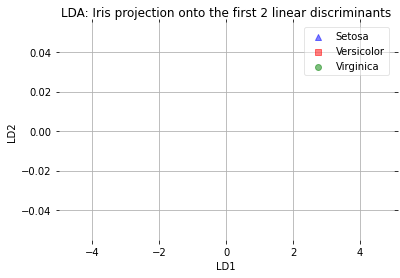

In [222]:
from matplotlib import pyplot as plt
%matplotlib inline
label_dict = {1: 'Setosa', 2: 'Versicolor', 3:'Virginica'}
def plot_step_lda():
    ax = plt.subplot(111)
    for label,marker,color in zip(range(1,4),('^', 's', 'o'),('blue', 'red', 'green')):
        print(X_lda[:,0])
        plt.scatter(x=X_lda[:,0].real[y == label],
                y=X_lda[:,1].real[y == label],
                marker=marker,
                color=color,
                alpha=0.5,
                label=label_dict[label]
                )

    plt.xlabel('LD1')
    plt.ylabel('LD2')

    leg = plt.legend(loc='upper right', fancybox=True)
    leg.get_frame().set_alpha(0.5)
    plt.title('LDA: Iris projection onto the first 2 linear discriminants')

    # hide axis ticks
    plt.tick_params(axis="both", which="both", bottom="off", top="off",  
            labelbottom="on", left="off", right="off", labelleft="on")

    # remove axis spines
    ax.spines["top"].set_visible(False)  
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False) 
    
    plt.xlim(-5,5)

    plt.grid()
    plt.tight_layout
    plt.show()

plot_step_lda()